<a href="https://colab.research.google.com/github/pouyyan/ML_Course_2024/blob/main/Mini%20Project%204/Mini_Project_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question 2

## Question2 Part 1

In [ ]:
!apt-get update
!apt-get install -y swig
!sudo apt-get update
!sudo apt-get install xvfb
!pip install rarfile --quiet
!pip install stable-baselines3 > /dev/null
!pip install box2d-py > /dev/null
!pip install gym==0.25.2
!sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 46 not upgraded.
Hit:1 https://cloud.r

In [ ]:
import io
import os
import glob
import torch
import base64
import stable_baselines3
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env
import gym
from gym import spaces
from gym.wrappers import RecordVideo
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import random
from collections import namedtuple, deque
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
gym.__version__

'0.25.2'

In [ ]:
# enviroment
env = gym.make('LunarLander-v2', new_step_api=True)

env.reset()

state_size = env.observation_space.shape[0]
action_size = env.action_space.n

#TODO: find action size: 4: 0- Do nothing 1- Fire left engine 2- Fire down engine 3- Fire right engine
state_size, action_size

(8, 4)

VIDEO

In [ ]:
display = Display(visible=0, size=(1400, 900))
display.start()


def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay loop controls style="height: 400px;">
                    <source src="data:video/mp4;base64,{0}" type="video/mp4" />
                 </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Question 2 Part 2

In [ ]:
# experience replay
Transition = namedtuple('Transition',('state', 'action', 'next_state', 'reward', 'done'))

random.seed(6)
torch.manual_seed(6)

class ExperienceReplay():
    def __init__(self, capacity) -> None:
        self.memory = deque([], maxlen=capacity)

    def store_trans(self, s, a, sp, r, done):
        transition = Transition(s, a, sp, r, done)
        self.memory.append(transition)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### DQN

In [ ]:
class DeepQNetwork(nn.Module):
    def __init__(self, state_size, action_size) -> None:
        super(DeepQNetwork, self).__init__()

        net_list = nn.ModuleList([
            torch.nn.Linear(state_size, 512),
            torch.nn.ReLU(),
            torch.nn.LayerNorm(512),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.LayerNorm(512),
            torch.nn.Dropout(0.1),
            torch.nn.Linear(512, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, action_size)])

        self.net = torch.nn.Sequential(*net_list).to(device)

    def forward(self, x):
        # TODO: forward propagation
        # NOTE: use ReLu for activation function in all layers
        # NOTE: last layer has no activation function (predict action)
        # ReLU is created in init, no need here
        x.to(device)
        x = self.net(x)
        return x

#### DQN agent

In [ ]:
class DQNAgent():
    # NOTE: DON'T change initial values
    def __init__(self, state_size, action_size, batch_size,
                 gamma=0.99, buffer_size=25000, alpha=1e-4):

        self.state_size = state_size
        self.action_size = action_size
        # hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma
        # experience replay
        self.experience_replay = ExperienceReplay(buffer_size)
        # network
        self.value_net = DeepQNetwork(state_size, action_size).to(device)
        # optimizer
        self.optimizer = optim.Adam(self.value_net.parameters(), lr=alpha)

    def take_action(self, state, eps=0.0):
        self.value_net.eval()
        rand_eps = random.random()
        if rand_eps > eps:
            with torch.no_grad():
                state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                action_values = self.value_net(state_tensor)
                return torch.argmax(action_values).item()
        else:
            return np.random.randint(0, self.action_size)

    def update_params(self):
        if len(self.experience_replay) < self.batch_size:
            return

        batch = Transition(*zip(*self.experience_replay.sample(self.batch_size)))
        state_batch = torch.tensor(batch.state, dtype=torch.float32).to(device)
        action_batch = torch.tensor(batch.action).unsqueeze(1).to(device)
        next_state_batch = torch.tensor(batch.next_state, dtype=torch.float32).to(device)
        reward_batch = torch.tensor(batch.reward, dtype=torch.float32).unsqueeze(1).to(device)
        done_batch = torch.tensor(batch.done, dtype=torch.float32).unsqueeze(1).to(device)

        # calculate loss w.r.t DQN algorithm
        self.value_net.train()

        # STEP1
        q_expected = self.value_net(state_batch).gather(1, action_batch)
        q_targets_next = self.value_net(next_state_batch).detach().max(1)[0].unsqueeze(1)
        q_targets = reward_batch + (self.gamma * q_targets_next * (1 - done_batch))
        loss = nn.functional.mse_loss(q_expected, q_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def save(self, fname):
        # TODO: save checkpoint
        torch.save(self.value_net.state_dict(), fname)

    def load(self, fname, device):
        # TODO: load checkpoint
        self.value_net.load_state_dict(torch.load(fname, map_location = device))

#### Batch 32

In [ ]:
# NOTE: DON'T change values
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01
BATCH_SIZE = 32

In [ ]:
# training phase

# TODO: create agent
agent = DQNAgent(state_size, action_size, batch_size=BATCH_SIZE)

crs = np.zeros(n_episodes) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards

# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    if i_episode % 50 == 0:
        env = RecordVideo(gym.make("LunarLander-v2"), f"./DQN/batch{BATCH_SIZE}/eps{i_episode}")
    else:
        env = gym.make("LunarLander-v2")
    state = env.reset()
    done = False
    cr = 0 # episode cummulative rewards
    while not done:
        env.render()
        # TODO: select and perform an action
        action = agent.take_action(state, eps)
#         print(action)
        # print(len(env.step(action)))
        next_state, reward, done, info = env.step(action)
        # TODO: store transition in experience replay
        agent.experience_replay.store_trans(state, action, next_state, reward, done)
        # TODO: update agent
        agent.update_params()
        # TODO: update current state and episode cummulative rewards
        state = next_state
        cr += reward

    # TODO: decay epsilon
    eps = eps * eps_decay_rate
    eps = max(eps, eps_end)
    # TODO: update current cummulative rewards and recent cummulative rewards
    crs[i_episode - 1] = cr
    crs_recent.append(cr)
    # TODO: save agent every 50 episodes
    if i_episode % 50 == 0:
        agent.save(f"DQN/DQN_batch{BATCH_SIZE}_eps{i_episode}.pt")

    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don

Episode 25	Average Reward: -189.06	Epsilon: 0.47
Episode 49	Average Reward: -33.24	Epsilon: 0.22

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain back

Episode 50	Average Reward: -22.67	Epsilon: 0.22


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 75	Average Reward: 136.05	Epsilon: 0.10
Episode 99	Average Reward: 149.92	Epsilon: 0.05

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 100	Average Reward: 150.00	Epsilon: 0.05


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 125	Average Reward: 210.37	Epsilon: 0.02
Episode 149	Average Reward: 239.17	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 150	Average Reward: 241.77	Epsilon: 0.01


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 175	Average Reward: 229.44	Epsilon: 0.01
Episode 199	Average Reward: 209.87	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 200	Average Reward: 211.25	Epsilon: 0.01


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 225	Average Reward: 234.66	Epsilon: 0.01
Episode 249	Average Reward: 247.18	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 250	Average Reward: 245.69	Epsilon: 0.01


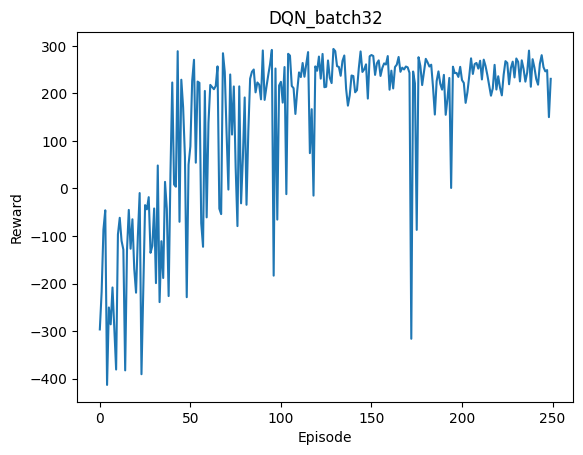

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.arange(len(crs)), crs)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.title(f"DQN_batch{BATCH_SIZE}")
plt.savefig(f"DQN_batch{BATCH_SIZE}.pdf")
plt.show()

#### Batch 64

In [ ]:
# NOTE: DON'T change values
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01
BATCH_SIZE = 64

In [ ]:
# training phase

# TODO: create agent
agent = DQNAgent(state_size, action_size, batch_size=BATCH_SIZE)

crs = np.zeros(n_episodes) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards

# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    if i_episode % 50 == 0:
        env = RecordVideo(gym.make("LunarLander-v2"), f"./DQN/batch{BATCH_SIZE}/eps{i_episode}")
    else:
        env = gym.make("LunarLander-v2")
    state = env.reset()
    done = False
    cr = 0 # episode cummulative rewards
    while not done:
        env.render()
        # TODO: select and perform an action
        action = agent.take_action(state, eps)
#         print(action)
        # print(len(env.step(action)))
        next_state, reward, done, info = env.step(action)
        # TODO: store transition in experience replay
        agent.experience_replay.store_trans(state, action, next_state, reward, done)
        # TODO: update agent
        agent.update_params()
        # TODO: update current state and episode cummulative rewards
        state = next_state
        cr += reward

    # TODO: decay epsilon
    eps = eps * eps_decay_rate
    eps = max(eps, eps_end)
    # TODO: update current cummulative rewards and recent cummulative rewards
    crs[i_episode - 1] = cr
    crs_recent.append(cr)
    # TODO: save agent every 50 episodes
    if i_episode % 50 == 0:
        agent.save(f"DQN/DQN_batch{BATCH_SIZE}_eps{i_episode}.pt")

    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don

Episode 25	Average Reward: -111.76	Epsilon: 0.47
Episode 49	Average Reward: -15.83	Epsilon: 0.22

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain back

Episode 50	Average Reward: -9.13	Epsilon: 0.22


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 75	Average Reward: 77.34	Epsilon: 0.10
Episode 99	Average Reward: 148.94	Epsilon: 0.05

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 100	Average Reward: 146.64	Epsilon: 0.05


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 125	Average Reward: 190.09	Epsilon: 0.02
Episode 149	Average Reward: 181.37	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 150	Average Reward: 184.94	Epsilon: 0.01


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 175	Average Reward: 212.48	Epsilon: 0.01
Episode 199	Average Reward: 215.81	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 200	Average Reward: 216.42	Epsilon: 0.01


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 225	Average Reward: 206.63	Epsilon: 0.01
Episode 249	Average Reward: 220.87	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 250	Average Reward: 220.17	Epsilon: 0.01


In [ ]:
BATCH_SIZE

64

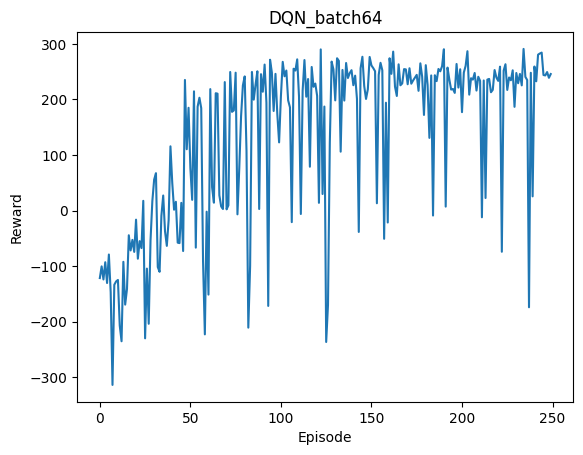

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.arange(len(crs)), crs)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.title(f"DQN_batch{BATCH_SIZE}")
plt.savefig(f"DQN_batch{BATCH_SIZE}.pdf")
plt.show()

#### Batch 128

In [ ]:
# NOTE: DON'T change values
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01
BATCH_SIZE = 128

In [ ]:
# training phase

# TODO: create agent
agent = DQNAgent(state_size, action_size, batch_size=BATCH_SIZE)

crs = np.zeros(n_episodes) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards

# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    if i_episode % 50 == 0:
        env = RecordVideo(gym.make("LunarLander-v2"), f"./DQN/batch{BATCH_SIZE}/eps{i_episode}")
    else:
        env = gym.make("LunarLander-v2")
    state = env.reset()
    done = False
    cr = 0 # episode cummulative rewards
    while not done:
        env.render()
        # TODO: select and perform an action
        action = agent.take_action(state, eps)
#         print(action)
        # print(len(env.step(action)))
        next_state, reward, done, info = env.step(action)
        # TODO: store transition in experience replay
        agent.experience_replay.store_trans(state, action, next_state, reward, done)
        # TODO: update agent
        agent.update_params()
        # TODO: update current state and episode cummulative rewards
        state = next_state
        cr += reward

    # TODO: decay epsilon
    eps = eps * eps_decay_rate
    eps = max(eps, eps_end)
    # TODO: update current cummulative rewards and recent cummulative rewards
    crs[i_episode - 1] = cr
    crs_recent.append(cr)
    # TODO: save agent every 50 episodes
    if i_episode % 50 == 0:
        agent.save(f"DQN/DQN_batch{BATCH_SIZE}_eps{i_episode}.pt")

    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don

Episode 25	Average Reward: -97.05	Epsilon: 0.47
Episode 49	Average Reward: -0.29	Epsilon: 0.22

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain back

Episode 50	Average Reward: 6.39	Epsilon: 0.22


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 75	Average Reward: 185.71	Epsilon: 0.10
Episode 99	Average Reward: 223.48	Epsilon: 0.05

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 100	Average Reward: 222.35	Epsilon: 0.05


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 125	Average Reward: 239.86	Epsilon: 0.02
Episode 149	Average Reward: 240.72	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 150	Average Reward: 241.88	Epsilon: 0.01


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 175	Average Reward: 192.90	Epsilon: 0.01
Episode 199	Average Reward: 214.19	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 200	Average Reward: 212.53	Epsilon: 0.01


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 225	Average Reward: 232.56	Epsilon: 0.01
Episode 249	Average Reward: 224.21	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/core.py:49: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/cont

Episode 250	Average Reward: 225.32	Epsilon: 0.01


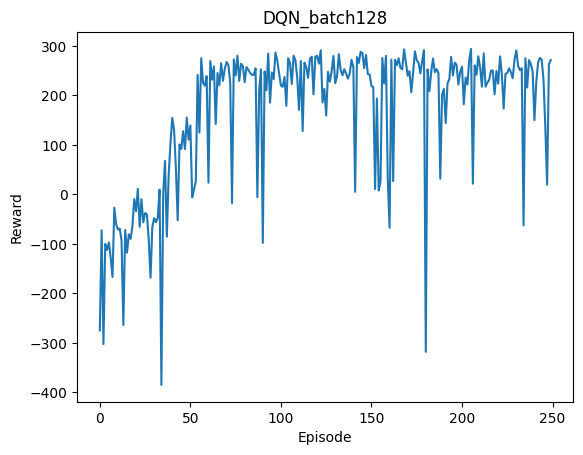

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(np.arange(len(crs)), crs)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.title(f"DQN_batch{BATCH_SIZE}")
plt.savefig(f"DQN_batch{BATCH_SIZE}.pdf")
plt.show()

## Question 2 Part 3

### DDQN

In [ ]:
class DDQNAgent():
    # NOTE: DON'T change initial values
    def __init__(self, state_size, action_size, batch_size,
                 gamma=0.99, buffer_size=25000, alpha=1e-4):
        # network parameter
        self.state_size = state_size
        self.action_size = action_size

        # hyperparameters
        self.batch_size = batch_size
        self.gamma = gamma

        # experience replay
        self.experience_buffer = ExperienceReplay(buffer_size)

        # networks
        self.value_net = DeepQNetwork(state_size, action_size).to(device)
        self.target_value_net = DeepQNetwork(state_size, action_size).to(device)
        self.update_target_network()

        # optimizer
        # TODO: create adam for optimizing network's parameter (learning rate=alpha)
        # NOTE: target network parameters DOSEN'T update with optimizer
        self.optimizer = optim.Adam(self.value_net.parameters(), lr=alpha)

    def take_action(self, state, eps=0.0):
        # TODO: take action using e-greedy policy
        # NOTE: takes action using the greedy policy with a probability of 1−𝜖 and a random action with a probability of 𝜖
        # NOTE:
        self.value_net.eval()
        rand_eps = random.random()
        if rand_eps > eps:
            with torch.no_grad():
                return torch.argmax(self.value_net(torch.tensor(state).to(device))).detach().cpu().numpy()
        else:
            return np.random.randint(0, self.action_size)

    def update_params(self):
        if len(self.experience_buffer) < self.batch_size:
            return
        # transition batch
        batch = Transition(*zip(*self.experience_buffer.sample(self.batch_size)))

        state_batch = torch.from_numpy(np.vstack(batch.state)).float().to(device)
        action_batch = torch.tensor(np.vstack(batch.action)).long().to(device)
        next_state_batch = torch.from_numpy(np.vstack(batch.next_state)).float().to(device)
        reward_batch = torch.tensor(np.vstack(batch.reward)).float().to(device)
        done_batch = torch.tensor(np.vstack(batch.done)).to(device)

        # calculate loss w.r.t DQN algorithm
        self.value_net.train()
        # STEP1
        q_targets_next = self.target_value_net(next_state_batch).detach().max(1)[0].unsqueeze(1)
        # STEP2
        # TODO: compute Q values [Q(s_t, a)]
        q_targets = reward_batch + self.gamma * q_targets_next * (1 - done_batch*1)
        q_expected = self.value_net(state_batch).gather(1, action_batch)
        # STEP3
        # TODO: compute mse loss
        loss = nn.functional.mse_loss(q_expected, q_targets)
        # TODO: optimize the model
        # NOTE: DON'T forget to set the gradients to zeros
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        # TODO: copy main network parameters to target network parameters
        self.target_value_net = copy.deepcopy(self.value_net)

    def save(self, fname):
        # TODO: save checkpoint
        torch.save(self.value_net, fname)

    def load(self, fname, device):
        # TODO: load checkpoint
        self.value_net = torch.load(fname, device)

#### Batch 32

In [ ]:
# NOTE: DON'T change values
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01
BATCH_SIZE = 32

In [ ]:
import copy

# TODO: create agent
agent = DDQNAgent(state_size, action_size, batch_size=BATCH_SIZE)

crs = np.zeros(n_episodes) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards

# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    if i_episode % 100 == 0:
        env = RecordVideo(gym.make("LunarLander-v2"), f"./DDQN/batch{BATCH_SIZE}/eps{i_episode}")
    elif i_episode % 250 == 0:
        env = RecordVideo(gym.make("LunarLander-v2"), f"./DDQN/batch{BATCH_SIZE}/eps{i_episode}")
    else:
        env = gym.make("LunarLander-v2")
    state = env.reset()
    done = False
    cr = 0 # episode cummulative rewards
    action_count = 0
    while not done:
        # TODO: select and perform an action
        action = agent.take_action(state, eps)
        next_state, reward, done, info = env.step(action)
        # TODO: store transition in experience replay
        agent.experience_buffer.store_trans(state, action, next_state, reward, done)
        # TODO: update agent
        agent.update_params()
        # TODO: update current state and episode cummulative rewards
        state = next_state
        cr += reward
        action_count += 1
        if action_count % 5 == 0:
            agent.update_target_network()

    # TODO: decay epsilon
    eps = eps * eps_decay_rate
    eps = max(eps, eps_end)

    # TODO: update current cummulative rewards and recent cummulative rewards
    crs[i_episode - 1] = cr
    crs_recent.append(cr)

    # TODO: save agent every 50 episodes
    if i_episode % 50 == 0:
        agent.save(f"DDQN_batch{BATCH_SIZE}_eps{i_episode}.pt")

    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 25	Average Reward: -150.97	Epsilon: 0.47
Episode 50	Average Reward: -79.37	Epsilon: 0.22
Episode 75	Average Reward: 104.00	Epsilon: 0.10
Episode 99	Average Reward: 111.33	Epsilon: 0.05

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool,

Episode 100	Average Reward: 102.22	Epsilon: 0.05


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 125	Average Reward: 97.00	Epsilon: 0.02
Episode 150	Average Reward: 195.93	Epsilon: 0.01
Episode 175	Average Reward: 210.60	Epsilon: 0.01
Episode 199	Average Reward: 236.61	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  

Episode 200	Average Reward: 233.08	Epsilon: 0.01


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 225	Average Reward: 253.54	Epsilon: 0.01
Episode 249	Average Reward: 245.17	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  

Episode 250	Average Reward: 247.09	Epsilon: 0.01


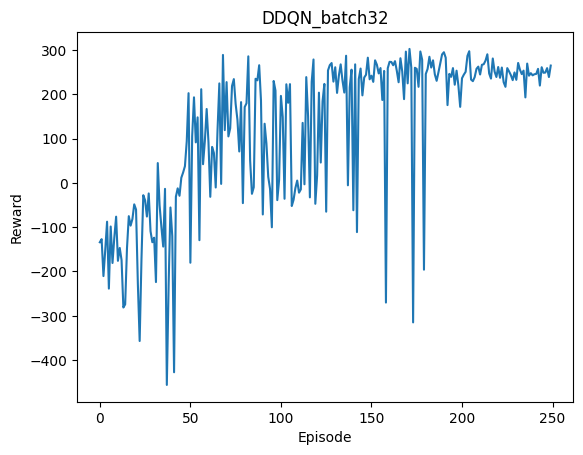

In [ ]:
fig = plt.figure()
plt.plot(np.arange(len(crs)), crs)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.title(f"DDQN_batch{BATCH_SIZE}")
plt.savefig(f"DDQN_batch{BATCH_SIZE}.pdf")
plt.show()

#### Batch 64

In [ ]:
# NOTE: DON'T change values
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01
BATCH_SIZE = 64

In [ ]:
agent = DDQNAgent(state_size, action_size, batch_size=BATCH_SIZE)

crs = np.zeros(n_episodes) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards

# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    if i_episode % 100 == 0:
        env = RecordVideo(gym.make("LunarLander-v2"), f"./DDQN/batch{BATCH_SIZE}/eps{i_episode}")
    elif i_episode % 250 == 0:
        env = RecordVideo(gym.make("LunarLander-v2"), f"./DDQN/batch{BATCH_SIZE}/eps{i_episode}")
    else:
        env = gym.make("LunarLander-v2")
    state = env.reset()
    done = False
    cr = 0 # episode cummulative rewards
    action_count = 0
    while not done:
        # TODO: select and perform an action
        action = agent.take_action(state, eps)
        next_state, reward, done, info = env.step(action)
        # TODO: store transition in experience replay
        agent.experience_buffer.store_trans(state, action, next_state, reward, done)
        # TODO: update agent
        agent.update_params()
        # TODO: update current state and episode cummulative rewards
        state = next_state
        cr += reward
        action_count += 1
        if action_count % 5 == 0:
            agent.update_target_network()

    # TODO: decay epsilon
    eps = eps * eps_decay_rate
    eps = max(eps, eps_end)

    # TODO: update current cummulative rewards and recent cummulative rewards
    crs[i_episode - 1] = cr
    crs_recent.append(cr)

    # TODO: save agent every 50 episodes
    if i_episode % 50 == 0:
        agent.save(f"DDQN_batch{BATCH_SIZE}_eps{i_episode}.pt")

    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

Episode 25	Average Reward: -149.39	Epsilon: 0.10
Episode 50	Average Reward: 17.23	Epsilon: 0.05
Episode 75	Average Reward: 179.75	Epsilon: 0.02
Episode 99	Average Reward: 209.53	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool,

Episode 100	Average Reward: 209.13	Epsilon: 0.01


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 125	Average Reward: 197.54	Epsilon: 0.01
Episode 150	Average Reward: 190.86	Epsilon: 0.01
Episode 175	Average Reward: 197.51	Epsilon: 0.01
Episode 199	Average Reward: 216.07	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  

Episode 200	Average Reward: 207.30	Epsilon: 0.01


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 225	Average Reward: 167.34	Epsilon: 0.01
Episode 249	Average Reward: 213.80	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  

Episode 250	Average Reward: 214.98	Epsilon: 0.01


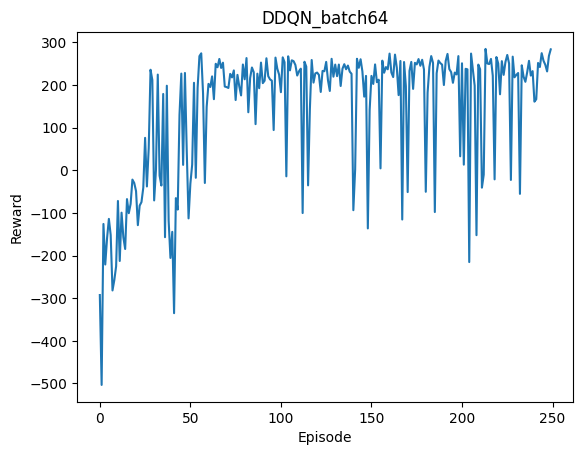

In [ ]:
fig = plt.figure()
plt.plot(np.arange(len(crs)), crs)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.title(f"DDQN_batch{BATCH_SIZE}")
plt.savefig(f"DDQN_batch{BATCH_SIZE}.pdf")
plt.show()

#### Batch 128

In [ ]:
# NOTE: DON'T change values
n_episodes = 250
eps = 1.0
eps_decay_rate = 0.97
eps_end = 0.01
BATCH_SIZE = 128

In [ ]:
agent = DDQNAgent(state_size, action_size, batch_size=BATCH_SIZE)

crs = np.zeros(n_episodes) # cummulative rewards
crs_recent = deque(maxlen=25) # recent cummulative rewards

# training loop
for i_episode in range(1, n_episodes+1):
    # TODO: initialize the environment and state
    if i_episode % 100 == 0:
        env = RecordVideo(gym.make("LunarLander-v2"), f"./DDQN/batch{BATCH_SIZE}/eps{i_episode}")
    elif i_episode % 250 == 0:
        env = RecordVideo(gym.make("LunarLander-v2"), f"./DDQN/batch{BATCH_SIZE}/eps{i_episode}")
    else:
        env = gym.make("LunarLander-v2")
    state = env.reset()
    done = False
    cr = 0 # episode cummulative rewards
    action_count = 0
    while not done:
        # TODO: select and perform an action
        action = agent.take_action(state, eps)
        next_state, reward, done, info = env.step(action)
        # TODO: store transition in experience replay
        agent.experience_buffer.store_trans(state, action, next_state, reward, done)
        # TODO: update agent
        agent.update_params()
        # TODO: update current state and episode cummulative rewards
        state = next_state
        cr += reward
        action_count += 1
        if action_count % 5 == 0:
            agent.update_target_network()

    # TODO: decay epsilon
    eps = eps * eps_decay_rate
    eps = max(eps, eps_end)

    # TODO: update current cummulative rewards and recent cummulative rewards
    crs[i_episode - 1] = cr
    crs_recent.append(cr)

    # TODO: save agent every 50 episodes
    if i_episode % 50 == 0:
        agent.save(f"DDQN_batch{BATCH_SIZE}_eps{i_episode}.pt")

    # print logs
    print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps), end="")
    if i_episode % 25 == 0:
        print('\rEpisode {}\tAverage Reward: {:.2f}\tEpsilon: {:.2f}'.format(i_episode, np.mean(crs_recent), eps))

Episode 25	Average Reward: -110.16	Epsilon: 0.47
Episode 50	Average Reward: -7.11	Epsilon: 0.22
Episode 75	Average Reward: 154.78	Epsilon: 0.10
Episode 99	Average Reward: 177.05	Epsilon: 0.05

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool,

Episode 100	Average Reward: 178.00	Epsilon: 0.05


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 125	Average Reward: 194.13	Epsilon: 0.02
Episode 150	Average Reward: 212.64	Epsilon: 0.01
Episode 175	Average Reward: 226.51	Epsilon: 0.01
Episode 199	Average Reward: 224.40	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  

Episode 200	Average Reward: 224.15	Epsilon: 0.01


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 225	Average Reward: 243.81	Epsilon: 0.01
Episode 249	Average Reward: 257.16	Epsilon: 0.01

/usr/local/lib/python3.10/dist-packages/gym/wrappers/monitoring/video_recorder.py:78: DeprecationWarning: WARN: Recording ability for environment LunarLander-v2 initialized with `render_mode=None` is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  

Episode 250	Average Reward: 258.30	Epsilon: 0.01


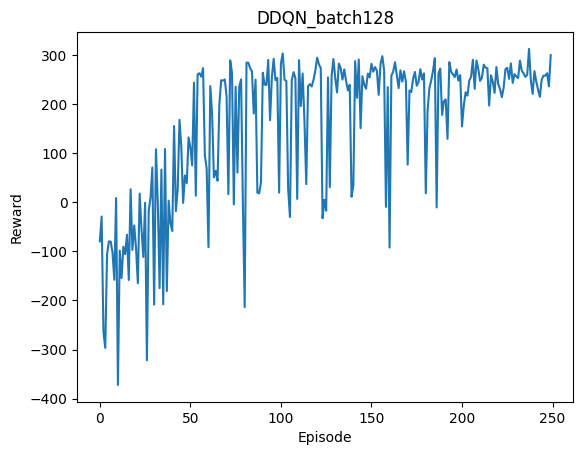

In [ ]:
fig = plt.figure()
plt.plot(np.arange(len(crs)), crs)
plt.ylabel('Reward')
plt.xlabel('Episode')
plt.title(f"DDQN_batch{BATCH_SIZE}")
plt.savefig(f"DDQN_batch{BATCH_SIZE}.pdf")
plt.show()